## Import packages

In [1]:
from gensim.models import Word2Vec
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import plotly.graph_objects as go
import os
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

## Load data 

In [2]:
# Đường dẫn đến file JSON
json_file_path = 'preprocessed_data_v3.json'

# Load dữ liệu từ file JSON vào DataFrame
df = pd.read_json(json_file_path, encoding='utf-8', lines=True)
# Hiển thị DataFrame
print(df)

                                        Processed_Content  Category
0       [lễ, chủ_tịch, tỉnh, trao, khen, chủ_tịch, tỉn...  Giao duc
1       [đề_xuất, giáo_dục, kỳ_vọng, đột_phá, dư_luận,...  Giao duc
2       [gần, cư_dân, mạng, truyền, đoạn, clip, ghi, h...  Giao duc
3       [căn_bệnh, thành_tích, địa_phương, biến, thi, ...  Giao duc
4       [phân_biệt, dạy, tác_phẩm, chương_trình, ban, ...  Giao duc
...                                                   ...       ...
114317  [hành_trình, giới_tính, bác_sĩ, trái, chỉnh_sử...  Suc khoe
114318  [khi, nàng, ham_muốn, phụ_nữ, tự_động, giản_đơ...  Suc khoe
114319  [khẳng_định, cúm_gà, thúc_giục, quốc_gia, thàn...  Suc khoe
114320  [bệnh_nhân, nhiễm, chiều, viện, vệ_sinh, dịch_...  Suc khoe
114321  [tập_thể_dục, tập, tối, đốt, calo, tập, trao_đ...  Suc khoe

[114322 rows x 2 columns]


In [3]:
print(df['Processed_Content'].count())
print(df['Category'].nunique())

114322
12


In [3]:
news = df['Processed_Content'].tolist()

## Train Word2Vec model

In [4]:
# Tên tệp tin chứa mô hình đã đào tạo
MODEL_FILENAME = "word2vec_model_100dim_10min.save"
MODEL_FOLDER = "./models"
sep = os.sep
# Kiểm tra xem mô hình đã được đào tạo và lưu trữ chưa
if not os.path.exists(MODEL_FOLDER+ sep + MODEL_FILENAME):
    # Đo thời gian bắt đầu đào tạo
    start_time = time.time()

    # Đào tạo mô hình Word2Vec
    word_model = Word2Vec(news, size=100, min_count=10, iter=10, workers=16, window=5)

    # Đo thời gian kết thúc đào tạo
    end_time = time.time()

    # In ra thời gian đào tạo
    word2vec_training_time = end_time - start_time
    print(f"Training time: {word2vec_training_time} seconds")
    
    # Lưu trữ mô hình đã đào tạo
    word_model.save(MODEL_FOLDER + sep + MODEL_FILENAME)
else:
    # Nếu mô hình đã được đào tạo và lưu trữ, tải lại mô hình từ tệp tin
    word_model = Word2Vec.load(MODEL_FOLDER+ sep + MODEL_FILENAME)

Training time: 195.35592603683472 seconds


## Train Doc2Vec model

In [4]:
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(news)]

In [6]:
# Xây dựng mô hình Doc2Vec
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=10, workers=16, epochs=10)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

In [8]:
# Lưu mô hình
MODEL_FILENAME = "doc2vec_model_100dim_10min.save"
MODEL_FOLDER = "./models"
sep = os.sep
doc2vec_model.save(MODEL_FOLDER + sep + MODEL_FILENAME)

## Check

In [9]:
word2vec_model_path = './models/word2vec_model_100dim_10min.save'
doc2vec_model_path = './models/doc2vec_model_100dim_10min.save'

# Load các mô hình
word2vec_model = Word2Vec.load(word2vec_model_path)
doc2vec_model = Doc2Vec.load(doc2vec_model_path)

In [12]:
# check the most similar word to 'trái_cây'
# Lấy kết quả tương quan từ model
similar_words = word2vec_model.wv.most_similar('trái_cây')

# Chuyển đổi kết quả thành DataFrame
df = pd.DataFrame(similar_words, columns=['Từ', 'Độ tương quan'])

# In bảng
print(df)

             Từ  Độ tương quan
0       hoa_quả       0.859406
1      đóng_hộp       0.700002
2          bưởi       0.677834
3           rau       0.673588
4   tráng_miệng       0.658321
5       dâu_tây       0.644042
6       sinh_tố       0.638632
7         chuối       0.637572
8         salát       0.629449
9  sữa_đậu_nành       0.629392


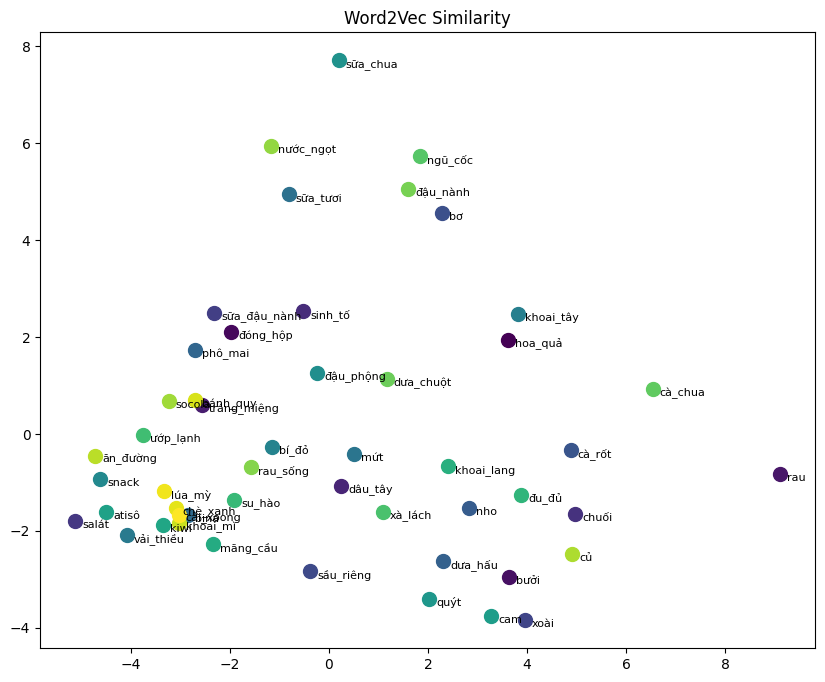

In [17]:


# Hàm để vẽ biểu đồ từ danh sách các từ và sự tương quan của chúng
def plot_word_similarity(model, word, topn, title='', xlim=None, ylim=None):
    similar_words = [pair[0] for pair in model.wv.most_similar(word, topn=topn)]
    vectors = [model.wv[word] for word in similar_words]

    # Giảm chiều dữ liệu xuống còn 2 chiều để vẽ biểu đồ
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)

    # Tạo một danh sách màu sắc đẹp
    colors = plt.cm.viridis(np.linspace(0, 1, len(similar_words)))

    # Vẽ biểu đồ và thêm chú thích (annotate)
    plt.figure(figsize=(10, 8))
    for i, (word, color) in enumerate(zip(similar_words, colors)):
        plt.scatter(result[i, 0], result[i, 1], color=color, s=100)
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), xytext=(5, -5), textcoords='offset points', fontsize=8)

    # Hiển thị title
    plt.title(title)


    plt.show()

# Vẽ biểu đồ cho Word2Vec 
plot_word_similarity(word2vec_model, 'trái_cây', topn=50, title='Word2Vec Similarity')




/tmp/ipykernel_43419/1562599339.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word_vecs = np.array([word2vec_model[w] for w in random_w])


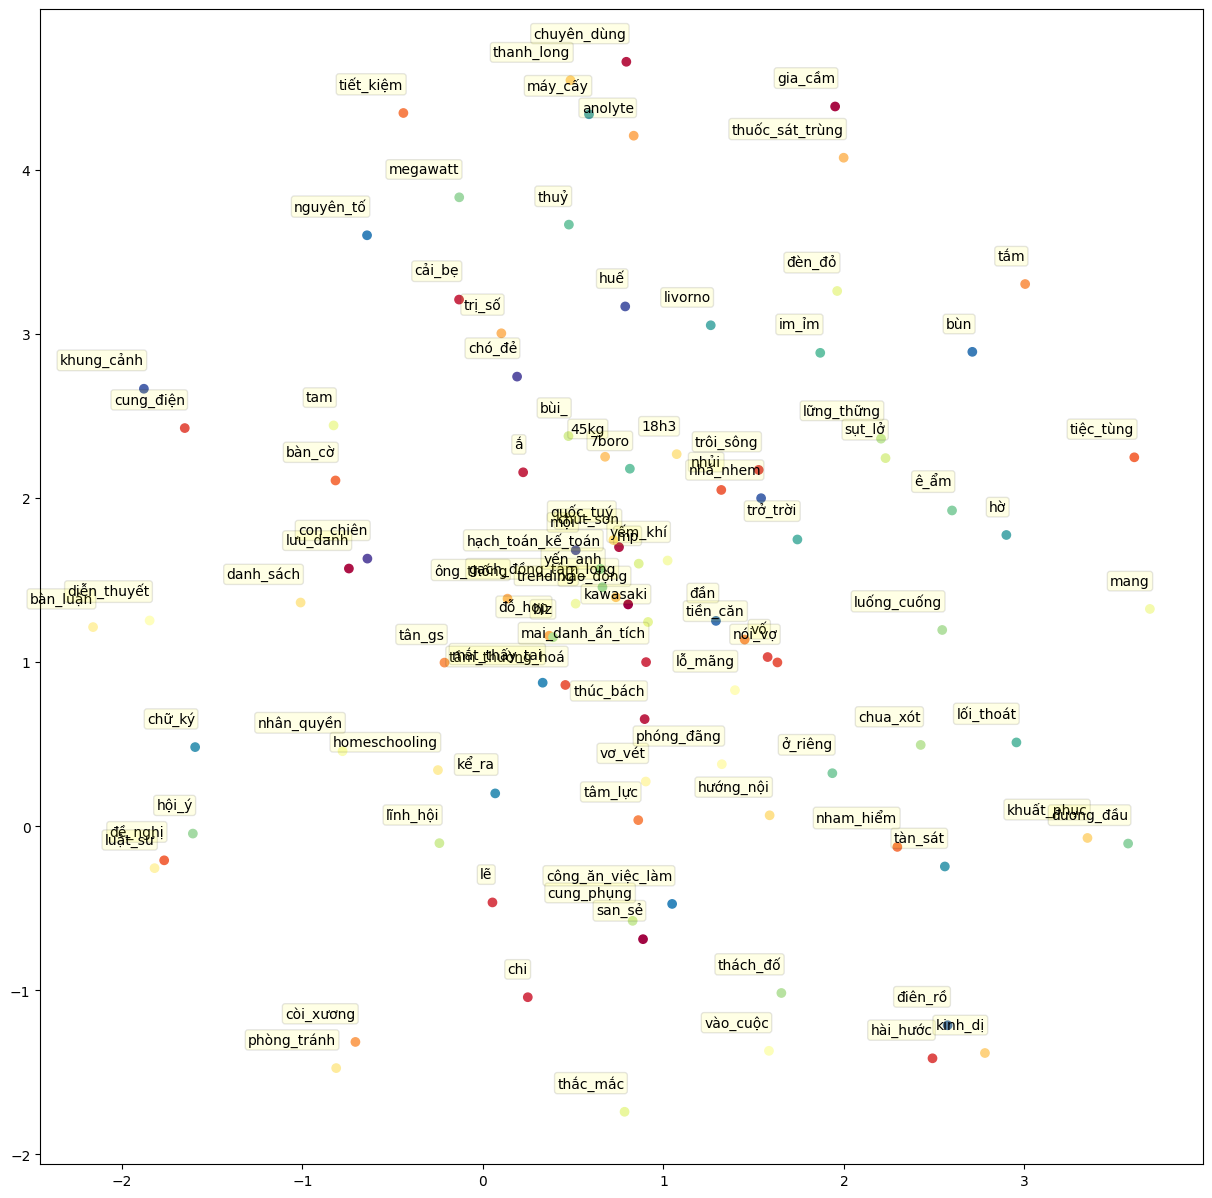

In [13]:
from sklearn.manifold import TSNE
import random

word2vec_weights = word2vec_model.wv.vectors
vocab_size, embedding_size = word2vec_weights.shape

def token2word(token):
    return word2vec_model.wv.index2word[token]

n_samples = 100
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([word2vec_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(15, 15))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

In [14]:
# check the most similar word to 'trái_cây'
# Lấy kết quả tương quan từ model
similar_words = doc2vec_model.wv.most_similar('trái_cây')

# Chuyển đổi kết quả thành DataFrame
df = pd.DataFrame(similar_words, columns=['Từ', 'Độ tương quan'])

# In bảng
print(df)

          Từ  Độ tương quan
0    hoa_quả       0.761342
1        rau       0.609643
2       xoài       0.576155
3    ngũ_cốc       0.556105
4      chuối       0.551483
5  sầu_riêng       0.549417
6       bưởi       0.549383
7        nho       0.544935
8    lê_tươi       0.541625
9    dâu_tây       0.531333


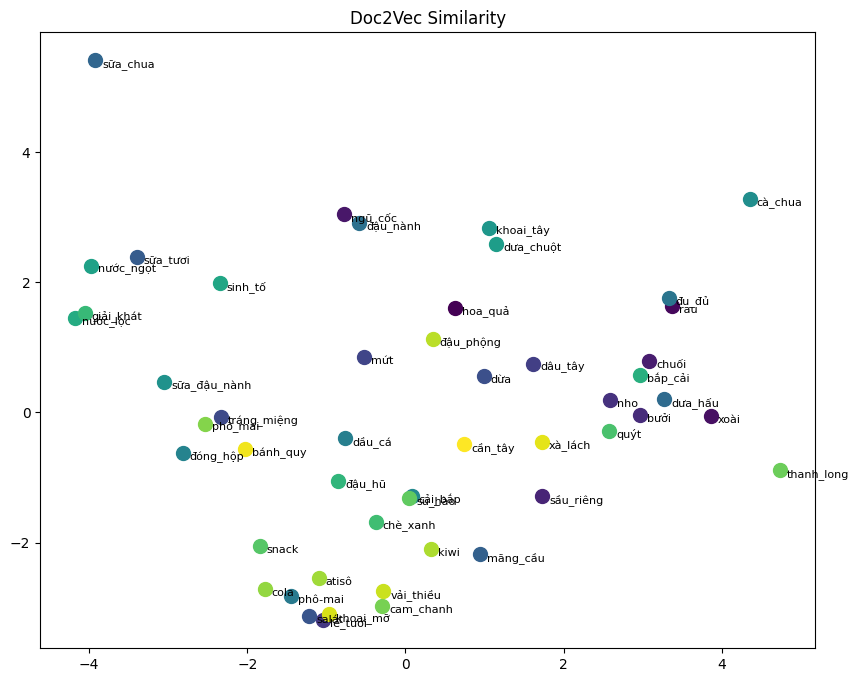

In [20]:
# Vẽ biểu đồ cho Word2Vec 
plot_word_similarity(doc2vec_model, 'trái_cây', topn=50, title='Doc2Vec Similarity')

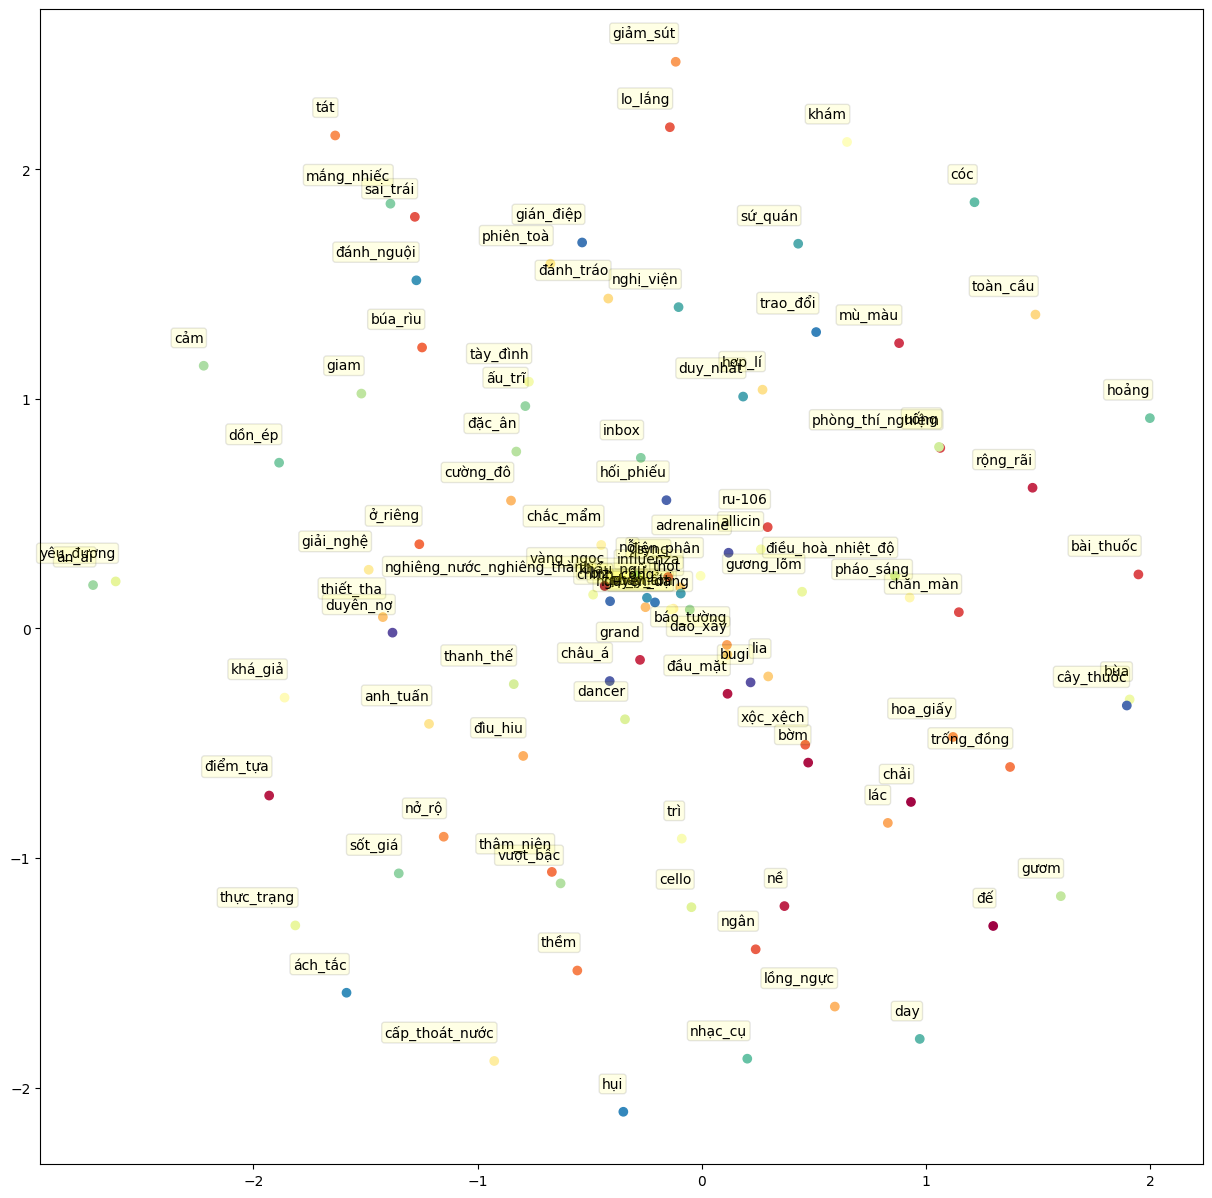

In [15]:
# Vẽ biểu đồ cho Doc2Vec
doc2vec_weights = doc2vec_model.wv.vectors
vocab_size, embedding_size = doc2vec_weights.shape

def token2word(token):
    return doc2vec_model.wv.index2word[token]

n_samples = 100
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate Word2Vec embeddings of each word
word_vecs = np.array([doc2vec_model[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(15, 15))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))